In [1]:
import torch, os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy.interpolate import interp1d
import random
from scipy import interpolate
from scipy import ndimage
from scipy.interpolate import griddata, NearestNDInterpolator

In [2]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

In [3]:
# date of datas
date = "0913"

ldr2hdr_dir = "./calibration/ldr2hdr/2023%s/"%date

# center points for all patches 20230913
all_patches_center_pts = np.array([[210, 130], [324,142], [442,142], [558, 147], [680,152], [792,154],
[200,250], [326,253], [440,256], [560, 260], [676,261], [792,267],
[190,366], [318,372], [440,372], [558,376], [676,380], [794,379],
[190,490], [314,496], [436,491], [558,492], [678,495], [800,495]])

# all_patches_center_pts = np.array([[130, 210], [142, 324], [142, 442], [147, 558], [152, 680], [154, 792],
#                    [250, 200], [253, 326], [256, 440], [260, 560], [261, 676], [267, 792],
#                    [366, 190], [372, 318], [372, 440], [376, 558], [380, 676], [379, 794],
#                    [490, 190], [496, 314], [491, 436], [492, 558], [495, 678], [495, 800]])

## Reconstruct hyperspectral Image

### PEF, CRF, DG Efficiency

In [4]:
# bring initial value of PEF and CRF
PEF = np.load('./dataset/image_formation/CRF_proj.npy')
map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
PEF = map_scale(PEF).astype(np.float32)
PEF = PEF[3:27] # from 430nm

CRF = np.load('./dataset/image_formation/CRF.npy')[:,1:].T # from 430nm

dg_intensity = np.load('./dataset/image_formation/dg_efficiency.npy')[1:] # from 430nm

In [5]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

In [6]:
# interpolated CRF for 5nm
CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

# interpolated PEF for 5nm
PEF_R = cubic_interpolation(new_wvls, wvls, PEF[:,0], 4)
PEF_G = cubic_interpolation(new_wvls, wvls, PEF[:,1], 4)
PEF_B = cubic_interpolation(new_wvls, wvls, PEF[:,2], 4)

# interpolated CRF for 5nm
dg_efficiency_R = cubic_interpolation(new_wvls, wvls, dg_intensity[:,0], 4)
dg_efficiency_G = cubic_interpolation(new_wvls, wvls, dg_intensity[:,1], 4)
dg_efficiency_B = cubic_interpolation(new_wvls, wvls, dg_intensity[:,2], 4)

In [7]:
CRF_intp = np.stack((CRF_R, CRF_G, CRF_B))
PEF_intp = np.stack((PEF_R, PEF_G, PEF_B))
dg_intensity_intp = np.stack((dg_efficiency_R, dg_efficiency_G, dg_efficiency_B))

#### Optimized paramter update

In [8]:
# bring optimized parameters
opt_param_final = np.load('./calibration/radiometric_cal/opt_params/opt_param_0915_detach_09500.npy')

# update parameter
CRF = CRF_intp.T * opt_param_final[:,3:-2]
PEF = PEF_intp.T * opt_param_final[:,:3]
dg_intensity_intp[2] = dg_intensity_intp[2] * opt_param_final[:,-1]
dg_intensity_intp[0] = dg_intensity_intp[0] * opt_param_final[:,-2]
DG_efficiency = dg_intensity_intp

(<AxesSubplot:title={'center':'5nm interpolated DG Efficiency'}>,
 Text(0.5, 1.0, '5nm interpolated DG Efficiency'))

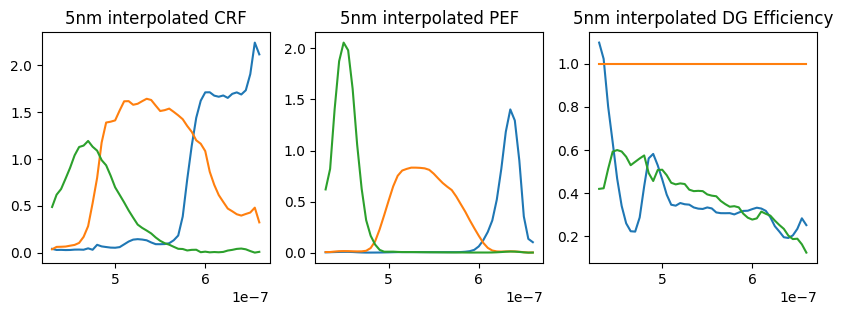

In [9]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(new_wvls, CRF), plt.title('5nm interpolated CRF')
plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

### PPG for HxW Image

In [10]:
# # load original hdr data
# hdr_imgs = np.load('./hdr_step5.npy') / 65535

# # median filter
# hdr_imgs_filtered_R = np.array([ndimage.median_filter(image[:,:,0], size=4) for image in hdr_imgs])
# hdr_imgs_filtered_G = np.array([ndimage.median_filter(image[:,:,1], size=4) for image in hdr_imgs])
# hdr_imgs_filtered_B = np.array([ndimage.median_filter(image[:,:,2], size=4) for image in hdr_imgs])

# hdr_imgs_filtered = np.stack((hdr_imgs_filtered_R, hdr_imgs_filtered_G, hdr_imgs_filtered_B), axis = 3)

# # save
# np.save('hdr_imgs_filtered.npy', hdr_imgs_filtered)

# load
hdr_imgs = np.load('hdr_imgs_filtered.npy')

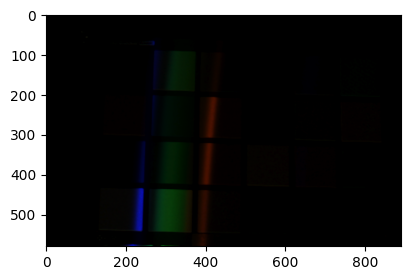

In [11]:
plt.figure(figsize=(5,3))
plt.imshow(hdr_imgs[0])

### Find Zero order index for HxW Image

In [12]:
zero_image_illum_idx = np.zeros(shape=(cam_H * cam_W))
hdr_imgs_reshape = hdr_imgs.reshape(n_illum, cam_H *cam_W, -1)

In [13]:
for i in range(cam_H * cam_W):
    max_idx = np.argmax(hdr_imgs_reshape[:,i].mean(axis = 1))
    zero_image_illum_idx[i] = max_idx

In [14]:
zero_image_illum_idx_reshape = zero_image_illum_idx.reshape(cam_H, cam_W)

In [15]:
# # check
# zero_image_illum_idx_reshape[130,210]

### Find 430nm, 660nm illum index

전체 이미지에 430nm illum index, 660nm illum index fitting하기 (v)

전체 이미지에 difference of zero order and first order fitting하기 (위랑 같은 거?)

전체 이미지에 430nm - 660nm illumination index 차이 fitting 하기 (v)

만약에 짤리면? 

- fitting 한 값보다 덜 나온다?
- 그러면 그냥 그 해당 nm reconstruct 하는걸로 끝내기

#### symmetry Test 

[102. 134. 167. 201. 237. 270. 101. 136. 168. 202. 235. 269. 100. 135.
 168. 201. 234. 268. 101. 135. 168. 201. 235. 270.]


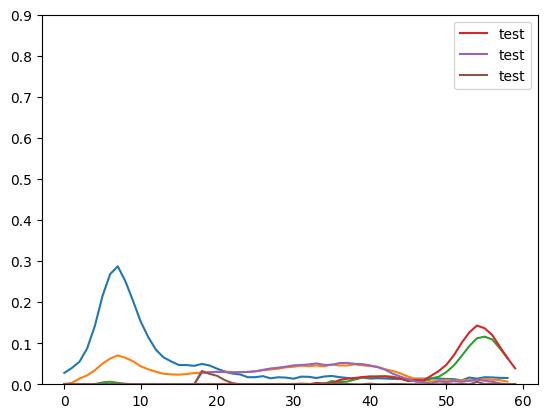

In [16]:
# bring first order illumination index for center points
peak_illum_idx = np.load('./peak_illum_idx.npy')
peak_illum_idx = peak_illum_idx.astype(np.int16)

# zero order 
zero_image_illum_idx_re = zero_image_illum_idx.reshape(580,890)

# check all patches zero illum index
print(zero_image_illum_idx_re[all_patches_center_pts[:,1], all_patches_center_pts[:,0]])

# bring patch ppg 
patches_rgb_real = np.load('patches_rgb_real.npy')

# Test 대칭성
Test = np.zeros(shape=(60,3))
Test[18:,:] = np.flip(patches_rgb_real[276:336,8,:])

plt.ylim([0,0.9])
plt.plot(patches_rgb_real[peak_illum_idx[8,-1]+1: peak_illum_idx[8,0],8,:])
plt.plot(Test, label = 'test')
plt.legend()

#### Interpolation

In [17]:
# difference between 430nm and 660nm
diff_image_illum_idx = np.zeros(shape=(cam_H, cam_W))
diffs = abs(peak_illum_idx[:,0] - peak_illum_idx[:,-1])

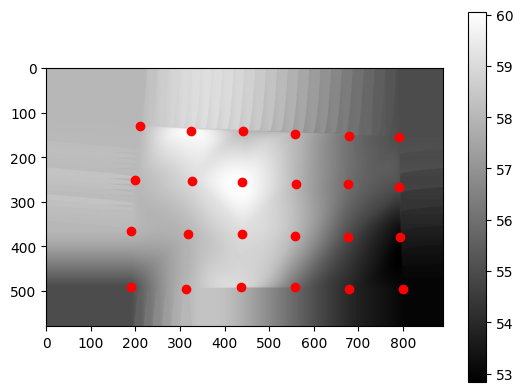

In [18]:
# Create a mesh grid for the image dimensions
grid_y, grid_x = np.mgrid[0:cam_H, 0:cam_W]

# Use griddata to interpolate
interp_values_diffs = griddata(all_patches_center_pts, diffs, (grid_x, grid_y), method='cubic')

# Step 2: Enhance the set of points and values using interpolated results
y_coords, x_coords = np.where(~np.isnan(interp_values_diffs))
enhanced_points = np.column_stack((y_coords, x_coords))
enhanced_values = interp_values_diffs[~np.isnan(interp_values_diffs)]

# Step 3: Extrapolate using the enhanced set of points and values
interpolator = NearestNDInterpolator(enhanced_points, enhanced_values)
extrapolated_values = interpolator(grid_y, grid_x)

# Assign the interpolated values to the image (assuming you want to assign them to the first channel)
diff_image_illum_idx[:, :] = extrapolated_values

# If you want to see the result, you can use matplotlib
plt.imshow(diff_image_illum_idx[:, :], cmap='gray'), plt.colorbar()
plt.scatter(all_patches_center_pts[:,0], all_patches_center_pts[:,1], c='red')  # plot the given points in red

plt.show()

In [19]:
# other values to 57 (mean difference)
# diff_image_illum_idx[np.isnan(diff_image_illum_idx) ==  True] = 57

# round values and astype int
diff_image_illum_idx = np.round(diff_image_illum_idx).astype(np.int16)

##### Make all illumination index to left (+1 order)

In [20]:
# zero illumination index for center points of patches
zero_illum_idx = zero_image_illum_idx_reshape[all_patches_center_pts[:,1], all_patches_center_pts[:,0]]

In [21]:
new_peak_illum_idx = np.zeros(shape=(24, 2))

for p in range(n_patches):
    difference_zero_430nm = abs(zero_illum_idx[p] - peak_illum_idx[p,0])
    if peak_illum_idx[p,0] < 200:
        new_peak_illum_idx[p,0] = zero_illum_idx[p] + (difference_zero_430nm + 1)
        new_peak_illum_idx[p,1] = zero_illum_idx[p] + (difference_zero_430nm + 1) + diffs[p]
    else:
        new_peak_illum_idx[p,0] = peak_illum_idx[p,0]
        new_peak_illum_idx[p,1] = peak_illum_idx[p,-1]

In [22]:
new_peak_image_illum_idx = np.zeros(shape=(cam_H, cam_W, 2))

In [23]:
## Only interpolation
# # Create a mesh grid for the image dimensions
# grid_y, grid_x = np.mgrid[0:cam_H, 0:cam_W]

# # Use griddata to interpolate
# interp_values_430nm = griddata(all_patches_center_pts, new_peak_illum_idx[:,0], (grid_x, grid_y), method='linear')
# interp_values_660nm = griddata(all_patches_center_pts, new_peak_illum_idx[:,1], (grid_x, grid_y), method='linear')

# # Assign the interpolated values to the image (assuming you want to assign them to the first channel)
# new_peak_image_illum_idx[:, :, 0] = interp_values_430nm
# new_peak_image_illum_idx[:, :, 1] = interp_values_660nm

# new_peak_image_illum_idx_re = new_peak_image_illum_idx.reshape(cam_H * cam_W, 2)

# plt.figure(figsize=(10,3))
# # If you want to see the result, you can use matplotlib
# plt.subplot(121), plt.imshow(new_peak_image_illum_idx[:, :, 0], cmap='gray'), plt.colorbar()
# plt.scatter(all_patches_center_pts[:,0], all_patches_center_pts[:,1], c='red')  # plot the given points in red

# plt.subplot(122), plt.imshow(new_peak_image_illum_idx[:, :, 1], cmap='gray'), plt.colorbar()
# plt.scatter(all_patches_center_pts[:,0], all_patches_center_pts[:,1], c='red')  # plot the given points in red

# plt.show()

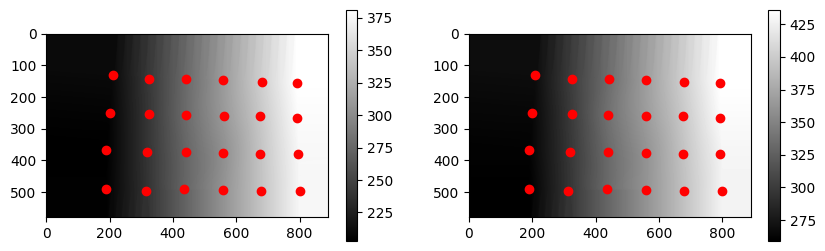

In [24]:
from scipy.interpolate import griddata, NearestNDInterpolator

# Create a mesh grid for the image dimensions
grid_y, grid_x = np.mgrid[0:cam_H, 0:cam_W]

# Use griddata to interpolate
interp_values_430nm = griddata(all_patches_center_pts, new_peak_illum_idx[:,0], (grid_x, grid_y), method='cubic')
interp_values_660nm = griddata(all_patches_center_pts, new_peak_illum_idx[:,1], (grid_x, grid_y), method='cubic')

# Step 2: Enhance the set of points and values using interpolated results
y_coords_430nm, x_coords_430nm = np.where(~np.isnan(interp_values_430nm))
y_coords_660nm, x_coords_660nm = np.where(~np.isnan(interp_values_660nm))

enhanced_points_430nm = np.column_stack((y_coords_430nm, x_coords_430nm))
enhanced_points_660nm = np.column_stack((y_coords_660nm, x_coords_660nm))

enhanced_values_430nm = interp_values_430nm[~np.isnan(interp_values_430nm)]
enhanced_values_660nm = interp_values_660nm[~np.isnan(interp_values_660nm)]

# Step 3: Extrapolate using the enhanced set of points and values
interpolator_430nm = NearestNDInterpolator(enhanced_points_430nm, enhanced_values_430nm)
interpolator_660nm = NearestNDInterpolator(enhanced_points_660nm, enhanced_values_660nm)

extrapolated_values_430nm = interpolator_430nm(grid_y, grid_x)
extrapolated_values_660nm = interpolator_660nm(grid_y, grid_x)

# Assign the interpolated values to the image (assuming you want to assign them to the first channel)
new_peak_image_illum_idx[:, :, 0] = extrapolated_values_430nm
new_peak_image_illum_idx[:, :, 1] = extrapolated_values_660nm

# new_peak_image_illum_idx[:, :, 0] = interp_values_430nm
# new_peak_image_illum_idx[:, :, 1] = interp_values_660nm

new_peak_image_illum_idx_re = new_peak_image_illum_idx.reshape(cam_H * cam_W, 2)

plt.figure(figsize=(10,3))
# If you want to see the result, you can use matplotlib
plt.subplot(121), plt.imshow(new_peak_image_illum_idx[:, :, 0], cmap='gray'), plt.colorbar()
plt.scatter(all_patches_center_pts[:,0], all_patches_center_pts[:,1], c='red')  # plot the given points in red

plt.subplot(122), plt.imshow(new_peak_image_illum_idx[:, :, 1], cmap='gray'), plt.colorbar()
plt.scatter(all_patches_center_pts[:,0], all_patches_center_pts[:,1], c='red')  # plot the given points in red

plt.show()

In [25]:
# change it to original illum index
orig_peak_image_illum_idx = np.zeros(shape=(cam_H*cam_W, 2))

for i in range(cam_H*cam_W):
    orig_peak_image_illum_idx[i,0] = zero_image_illum_idx[i] - abs(zero_image_illum_idx[i] - (new_peak_image_illum_idx_re[i,0]-1))
    orig_peak_image_illum_idx[i,1] = zero_image_illum_idx[i] - abs(zero_image_illum_idx[i] - (new_peak_image_illum_idx_re[i,1]-1))

orig_peak_image_illum_idx_re = orig_peak_image_illum_idx.reshape(cam_H, cam_W, 2)

In [26]:
# divide it to valid order / illum index
# new : new_peak_image_illum_idx_re
# orig : orig_peak_image_illum_idx

# if new index 430nm and 660nm difference is larger pick new index
# if not pick original index 

peak_image_illum_idx = np.zeros(shape=(cam_H*cam_W, 2))

new_peak_image_illum_idx_re_cp = new_peak_image_illum_idx_re.copy()
orig_peak_image_illum_idx_cp = orig_peak_image_illum_idx.copy()

for i in range(cam_H*cam_W):
    if new_peak_image_illum_idx_re[i,0] > 317:
        new_peak_image_illum_idx_re_cp[i,0] = 317
        new_peak_image_illum_idx_re_cp[i,1] = 317
        
    elif new_peak_image_illum_idx_re[i,1] > 317:
        new_peak_image_illum_idx_re_cp[i,1] = 317
        
    elif orig_peak_image_illum_idx[i,0] < 0:
         orig_peak_image_illum_idx_cp[i,0] = 0
         orig_peak_image_illum_idx_cp[i,1] = 0
         
    elif orig_peak_image_illum_idx[i,1] < 0:
        orig_peak_image_illum_idx_cp[i,1] = 0
        
    new_diff = abs(new_peak_image_illum_idx_re_cp[i,0] - new_peak_image_illum_idx_re_cp[i,1])
    orig_diff = abs(orig_peak_image_illum_idx_cp[i,0] - orig_peak_image_illum_idx_cp[i,1])
    
    if new_diff > orig_diff:
        peak_image_illum_idx[i,0] = new_peak_image_illum_idx_re[i,0]
        peak_image_illum_idx[i,1] = new_peak_image_illum_idx_re[i,1]
    
    elif new_diff <= orig_diff:
        peak_image_illum_idx[i,0] = orig_peak_image_illum_idx[i,0]
        peak_image_illum_idx[i,1] = orig_peak_image_illum_idx[i,1]

In [27]:
# make it to integers
peak_image_illum_idx = np.round(peak_image_illum_idx).astype(np.int32)
peak_image_illum_idx_re = peak_image_illum_idx.reshape(cam_H, cam_W, 2)

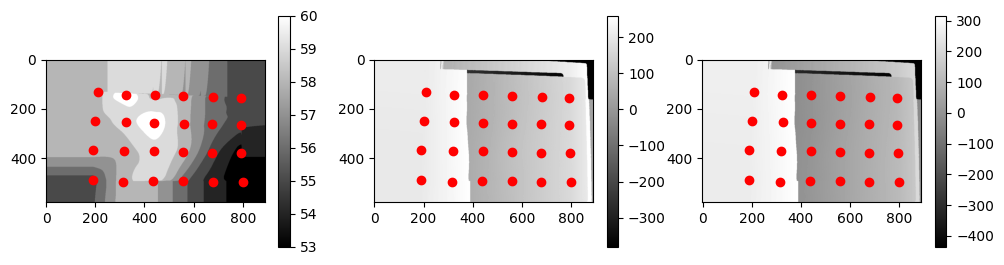

In [28]:
plt.figure(figsize=(12,3))

plt.subplot(131), plt.imshow(diff_image_illum_idx[:, :], cmap='gray'), plt.colorbar()
plt.scatter(all_patches_center_pts[:,0], all_patches_center_pts[:,1], c='red')  # plot the given points in red

plt.subplot(132), plt.imshow(peak_image_illum_idx_re[:, :, 0], cmap='gray'), plt.colorbar()
plt.scatter(all_patches_center_pts[:,0], all_patches_center_pts[:,1], c='red')  # plot the given points in red

plt.subplot(133), plt.imshow(peak_image_illum_idx_re[:, :, 1], cmap='gray'), plt.colorbar()
plt.scatter(all_patches_center_pts[:,0], all_patches_center_pts[:,1], c='red')  # plot the given points in red

plt.show()

#### find if each pixels get first order or minus order or both or none

In [29]:
# hdr_imgs_reshape_copy = hdr_imgs_reshape.copy()
# width = 50
# pfirst_or_mfirst = np.zeros(shape=(cam_H * cam_W))

# for i in range(cam_H * cam_W):

#     max_idx = np.argmax(hdr_imgs_reshape_copy[:,i].mean(axis = 1))
#     hdr_imgs_reshape_copy[max_idx-width:max_idx+width, i] = 0
    
#     pfirst = np.any(np.where(hdr_imgs_reshape_copy[:,i] > 0.05)[0] > max_idx)
#     mfirst = np.any(np.where(hdr_imgs_reshape_copy[:,i] > 0.05)[0] < max_idx)
    
#     if (pfirst == True) and (mfirst == False): # pfirst order만 존재
#         pfirst_or_mfirst[i] = 1
#     elif (pfirst == False) and (mfirst == True): # mfirst order만 존재
#         pfirst_or_mfirst[i] = -1
#     elif (pfirst == False) and (mfirst == False): # first order 없음 (배경)
#         pfirst_or_mfirst[i] = np.inf
#     else: # first order 둘다 있음
#         pfirst_or_mfirst[i] = 0

In [30]:
# for p in range(n_patches):
#     print('zero index :', zero_image_illum_idx_re[all_patches_center_pts[p,1], all_patches_center_pts[p,0]])
#     print('first order index :', peak_image_illum_idx_re[all_patches_center_pts[p,1], all_patches_center_pts[p,0]])

#### Diffraction grating efficiency for each pixels

In [31]:
# DG efficiency for all pixels
DG_efficiency_image = np.zeros(shape=(cam_H * cam_W, len(new_wvls)))

for i in range(cam_H * cam_W):
    if zero_image_illum_idx[i] > peak_image_illum_idx[i,0]: # 430nm # -1 order
        DG_efficiency_image[i,:] =  DG_efficiency[0]
    elif zero_image_illum_idx[i] < peak_image_illum_idx[i,0]: # +1 order
        DG_efficiency_image[i,:] =  DG_efficiency[2]
    else: # else
        DG_efficiency_image[i,:] = 0

In [32]:
# # test
# check = DG_efficiency_image == DG_efficiency[0]
# plt.imshow(check.reshape(580,890,47)[:,:,0]), plt.colorbar()

### First order interpolation 

In [33]:
position_430nm = peak_image_illum_idx[:,0]
position_660nm = peak_image_illum_idx[:,1]

start_idx = position_430nm
end_idx = position_660nm

first_illum_idx_final = []
for i in range(cam_H*cam_W):
    interval_array = np.linspace(start_idx[i], end_idx[i], 47)
    interval_array = np.round(interval_array).astype(np.int16)
    first_illum_idx_final.append(interval_array)
first_illum_idx_final = np.array(first_illum_idx_final)

In [34]:
first_illum_idx_final_reshape = first_illum_idx_final.reshape(cam_H, cam_W, len(new_wvls))

In [35]:
# for exception, put 0, 317 index
first_illum_idx_final_reshape[first_illum_idx_final_reshape >= 318] = 317
first_illum_idx_final_reshape[first_illum_idx_final_reshape < 0] = 0

In [36]:
# to make 47, cam_H, cam_W, 3 array
first_illum_idx_final_transp = first_illum_idx_final_reshape.transpose(2,0,1)
first_illum_idx_final_transp = np.repeat(first_illum_idx_final_transp[:,:,:,np.newaxis], 3, axis = 3)

In [37]:
# # make invalid values to 0
# cond = (first_illum_idx_final_transp >= 0) * (first_illum_idx_final_transp < 318)
# cond = cond * 1

# first_illum_idx_final_transp = first_illum_idx_final_transp * cond

# x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

# (first_illum_idx_final_transp == 318).sum()

# a = hdr_imgs[first_illum_idx_final_transp, x, y, z]

# a = a.reshape(47, cam_H * cam_W, 3)

# valid = a[10,:,:] > 0.

# for k in range(0, cam_W*cam_H, 100):
#     if valid[k,:].all() == True:
#         i, j = np.unravel_index(k, (cam_H, cam_W))
#         plt.scatter(i,j)

### Simulation

Text(0.5, 0, 'wavelength [nm]')

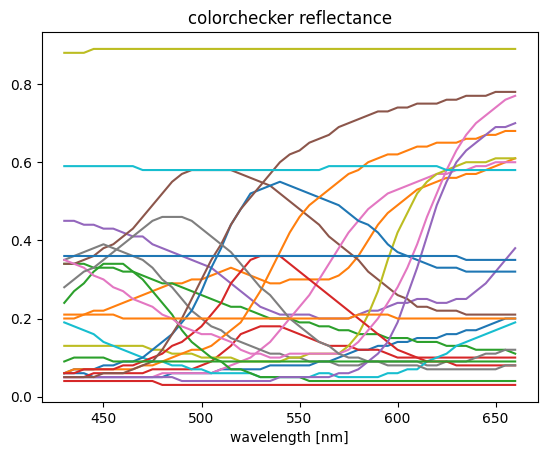

In [38]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max][4:-4]
ref_CC = ref_CC[ind_min:ind_max,:][4:-4]

plt.figure()
plt.plot(wvls_CC, ref_CC)
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [39]:
white_pattern = np.ones(shape = (1, 3))*0.8
white_pattern_hyp = white_pattern @ PEF.T
                    # 47, 1
Simulated_I_RGB = (ref_CC[:,18][:,np.newaxis] * white_pattern_hyp.transpose(1,0) * DG_efficiency[2][:,np.newaxis]) * CRF

In [40]:
x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')
GT_I_RGB = hdr_imgs[first_illum_idx_final_transp, x, y, z].transpose(1, 2, 0, 3)    

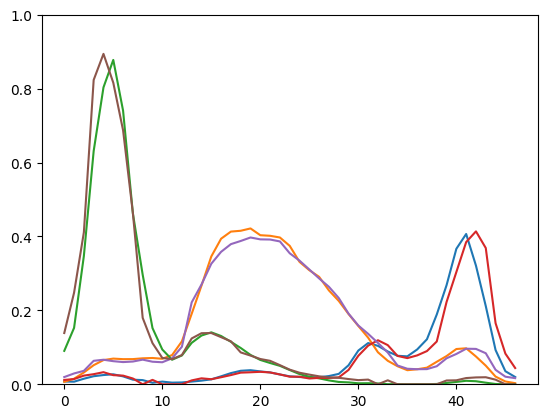

In [41]:
plt.ylim([0, 1])
plt.plot(Simulated_I_RGB, )
plt.plot(GT_I_RGB[490,190])

### SVD

In [42]:
# n_lambda = 47
# weight_D = 0.5
# device = 'cuda:0'

# # D matrix
# i_mat = np.eye(n_lambda)
# diagonal_indices = np.diag_indices(i_mat.shape[0])
# new_diagonal_indices_col = np.copy(diagonal_indices[1])
# new_diagonal_indices_col[:-1] = diagonal_indices[1][:-1] + 1
# i_mat[(diagonal_indices[0], new_diagonal_indices_col)] = -1
# D = i_mat
# D[-1] = i_mat[-2]

# D = torch.tensor(D, device=device)

# # to tensor, device
# CRF = torch.tensor(CRF, device=device).type(torch.float32)
# PEF = torch.tensor(PEF, device=device).type(torch.float32)
# hdr_imgs_t = torch.tensor(hdr_imgs, device=device)
# first_illum_idx_final_transp_t = torch.tensor(first_illum_idx_final_transp, device=device)
# DG_efficiency_image_t = torch.tensor(DG_efficiency_image.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls

# # pattern
# white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
# white_patt_hyp = white_patt @ PEF.T
# white_patt_hyp = white_patt_hyp.squeeze()

# CRF_sum = torch.tensor(CRF, device=device).sum(axis = 1)

# total_hyp_ref = []

# # summation of Image RGB channel
# I_C = hdr_imgs_t[first_illum_idx_final_transp_t.long(), x, y, z].permute(1, 2, 0, 3).sum(axis = 3).reshape(-1, n_lambda, 1) # H x W, wvls, 1
# A = (CRF_sum.unsqueeze(dim = 0) * white_patt_hyp * DG_efficiency_image_t).unsqueeze(dim =2) # HxW, wvls, 1

# # to batch
# pinv = torch.zeros(size=(cam_H, cam_W, n_lambda, n_lambda), device=device) # n_lambda
# r, c = 290, 445

# A = A.reshape(cam_H, cam_W, n_lambda)

# A1 = A[:r,:c]
# A2 = A[:r,c:]
# A3 = A[r:,:c]
# A4 = A[r:,c:]
# A_list = [A1,A2,A3,A4]

# # training loop over batches
# for batch_idx in range(len(A_list)):
#     print('batch:', batch_idx)
#     A_batch = (A_list[batch_idx]).to(device).reshape(r*c, n_lambda)
    
#     A_diag = torch.diag_embed((A_batch*A_batch).squeeze())
#     weight_D_DT = (weight_D*D.T@D).unsqueeze(dim = 0)

#     pinv_batch = torch.linalg.pinv(A_diag + weight_D_DT) # r*c, wvls, wvls
    
#     print('pinv calculated')
    
#     pinv_batch = pinv_batch.reshape(r, c, n_lambda, n_lambda)
    
#     if batch_idx == 0:
#         pinv[:r,:c]= pinv_batch
#     elif batch_idx == 1:
#         pinv[:r,c:]= pinv_batch
#     elif batch_idx == 2:
#         pinv[r:,:c]= pinv_batch
#     else:
#         pinv[r:,c:]= pinv_batch
    

# csj_x = pinv @ (A*I_C.reshape(cam_H*cam_W, n_lambda,1))

# total_hyp_ref = csj_x.squeeze()
# total_hyp_ref = total_hyp_ref.reshape(cam_H, cam_W, n_lambda)

In [43]:
n_lambda = 47
weight_D = 0.5
device = 'cuda:0'

# D matrix
i_mat = np.eye(n_lambda)
diagonal_indices = np.diag_indices(i_mat.shape[0])
new_diagonal_indices_col = np.copy(diagonal_indices[1])
new_diagonal_indices_col[:-1] = diagonal_indices[1][:-1] + 1
i_mat[(diagonal_indices[0], new_diagonal_indices_col)] = -1
D = i_mat
D[-1] = i_mat[-2]

D = torch.tensor(D, device=device)

# to tensor, device
CRF = torch.tensor(CRF, device=device).type(torch.float32)
PEF = torch.tensor(PEF, device=device).type(torch.float32)
hdr_imgs_t = torch.tensor(hdr_imgs, device=device)
first_illum_idx_final_transp_t = torch.tensor(first_illum_idx_final_transp, device=device)
DG_efficiency_image_t = torch.tensor(DG_efficiency_image.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls

# pattern
white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
white_patt_hyp = white_patt @ PEF.T
white_patt_hyp = white_patt_hyp.squeeze()

CRF_sum = torch.tensor(CRF, device=device).sum(axis = 1)

total_hyp_ref = []

# summation of Image RGB channel
I_C = hdr_imgs_t[first_illum_idx_final_transp_t.long(), x, y, z].permute(1, 2, 0, 3).sum(axis = 3).reshape(-1, n_lambda, 1) # H x W, wvls, 1
A = (CRF_sum.unsqueeze(dim = 0) * white_patt_hyp * DG_efficiency_image_t).unsqueeze(dim =2) # HxW, wvls, 1


c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [44]:
A_diag = torch.diag_embed((A*A).squeeze())

weight_D_DT = (weight_D*D.T@D).unsqueeze(dim = 0)

# (1)
# pinv = torch.linalg.pinv(A_diag + weight_D_DT) # r*c, wvls, wvls
# csj_x = pinv @ (A*I_C.reshape(cam_H*cam_W, n_lambda,1))

# (2)
csj_x = torch.linalg.solve(A_diag + weight_D_DT, A*I_C.reshape(cam_H*cam_W, n_lambda,1))

# (3)
# csj_x = torch.linalg.lstsq(A_diag + weight_D_DT, A*I_C.reshape(cam_H*cam_W, n_lambda,1))
# csj_x = csj_x.solution

total_hyp_ref = csj_x.squeeze()
total_hyp_ref = total_hyp_ref.reshape(cam_H, cam_W, n_lambda)

([<matplotlib.lines.Line2D at 0x18ead11c2c8>],
 [<matplotlib.lines.Line2D at 0x18ead11cf48>])

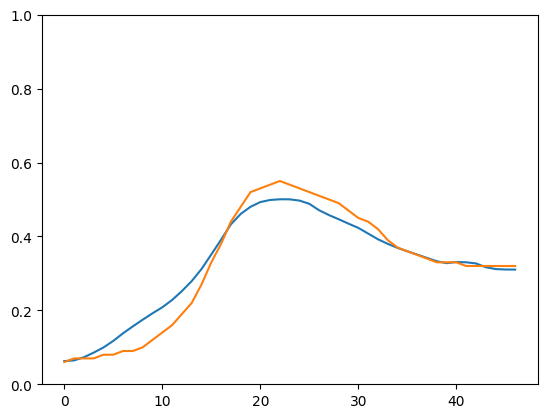

In [93]:
plt.ylim([0,1])
plt.plot(total_hyp_ref[241,696]), plt.plot(ref_CC[:,10])

In [88]:
ref_CC.shape

(47, 24)

In [76]:
CRF = np.array(CRF.detach().cpu().numpy())

In [78]:
a = total_hyp_ref@CRF

In [80]:
a.max()

71.8460839397288

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


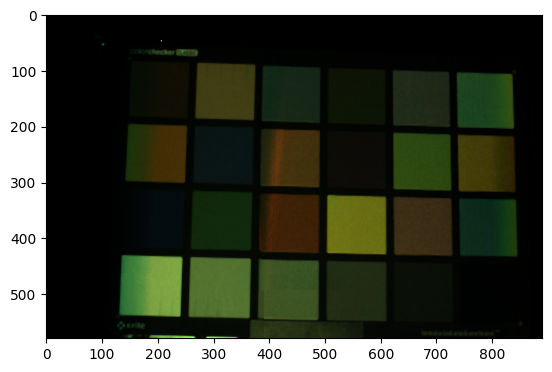

In [84]:
plt.imshow(a/60)

In [56]:
csj_x_vis = csj_x.reshape(cam_H, cam_W, n_lambda)

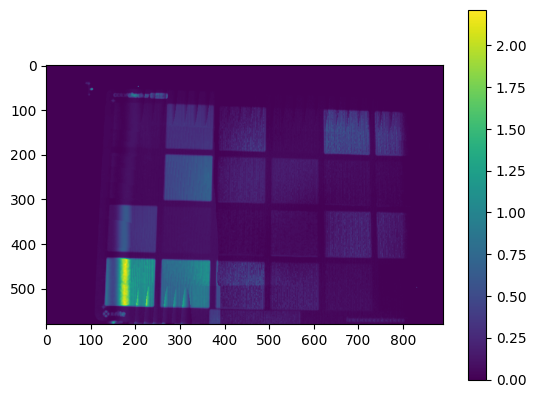

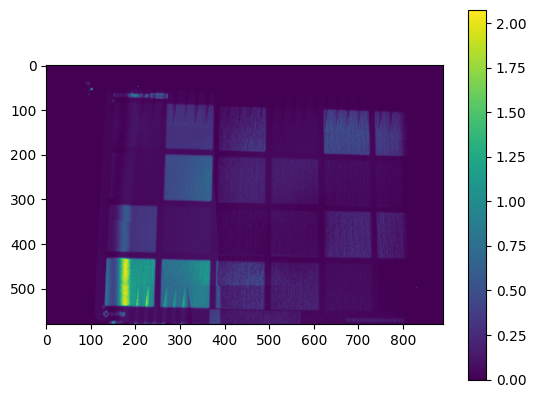

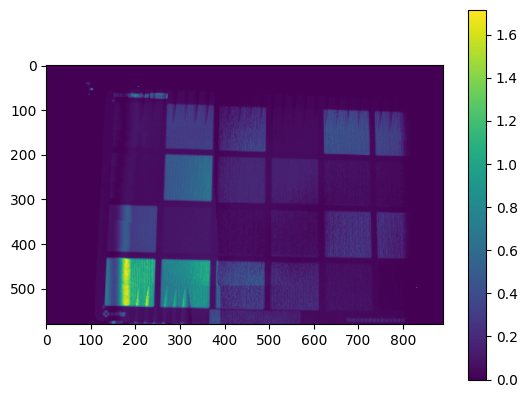

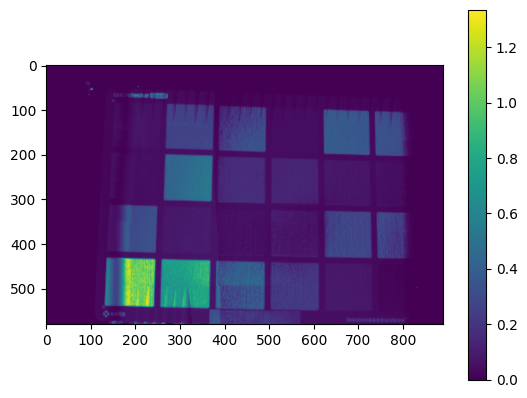

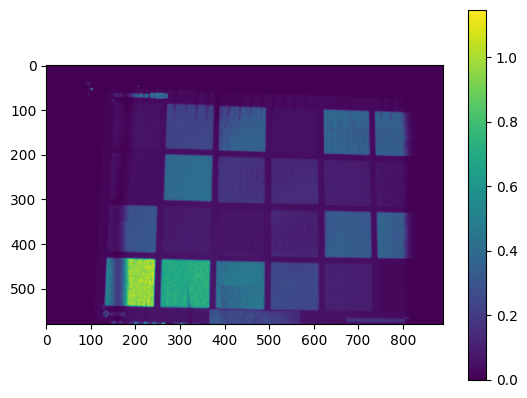

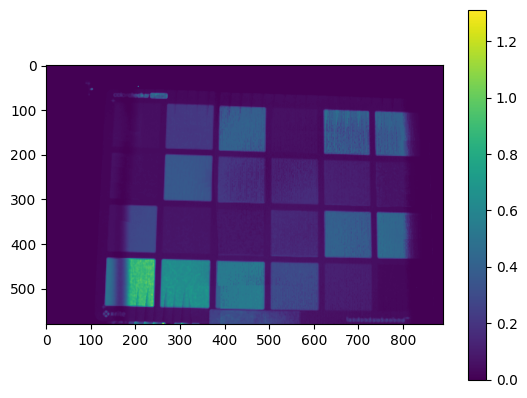

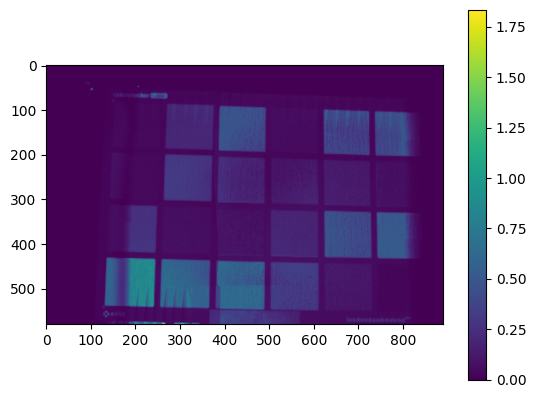

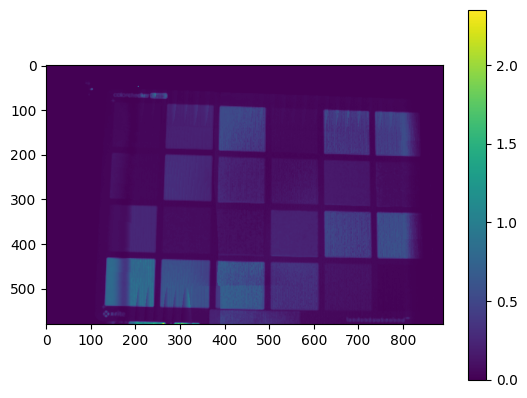

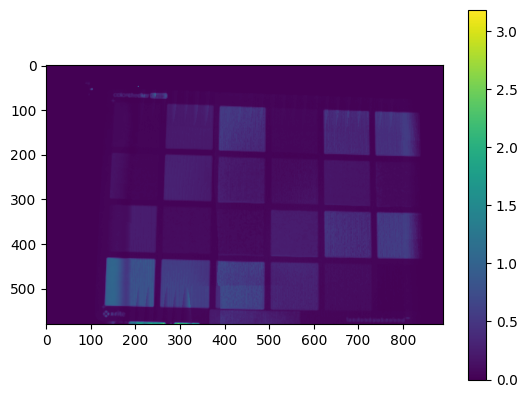

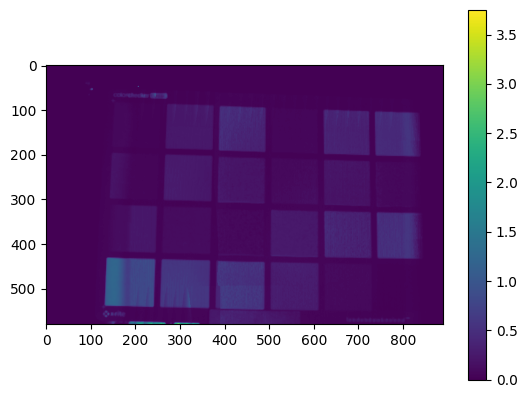

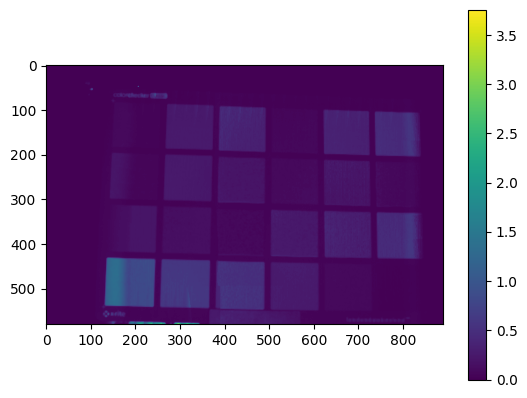

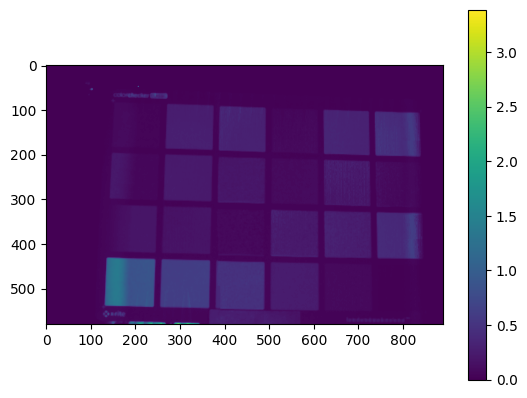

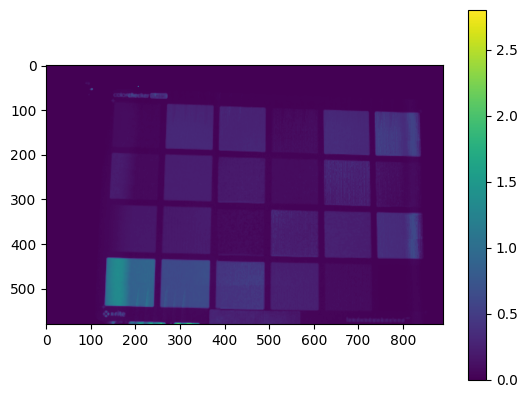

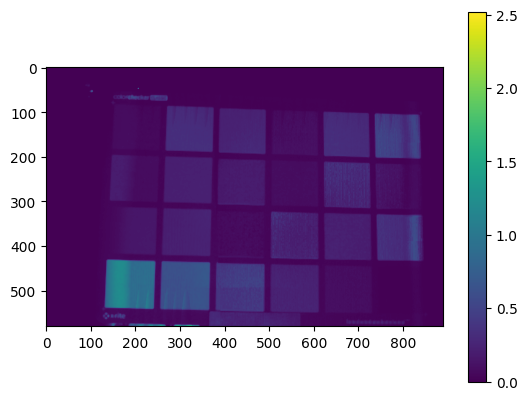

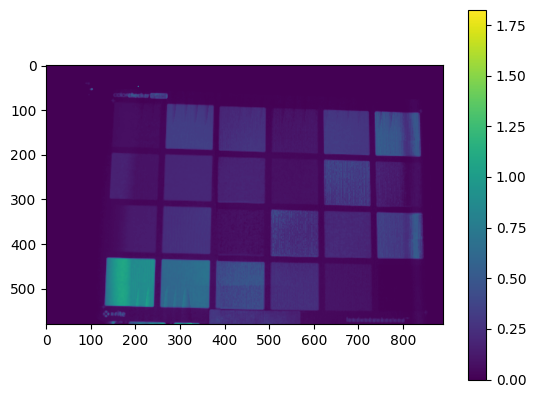

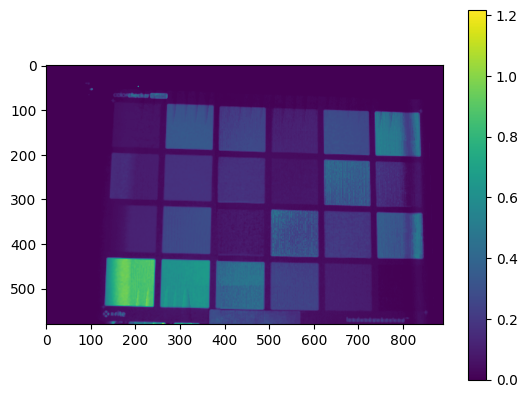

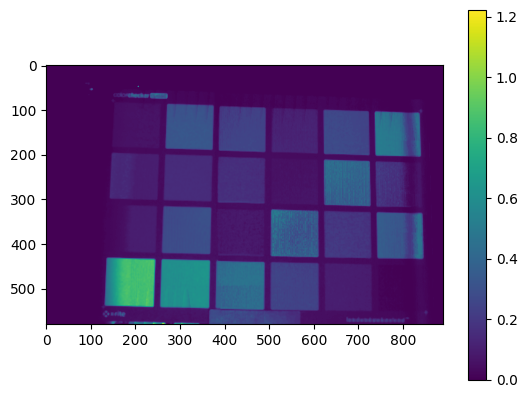

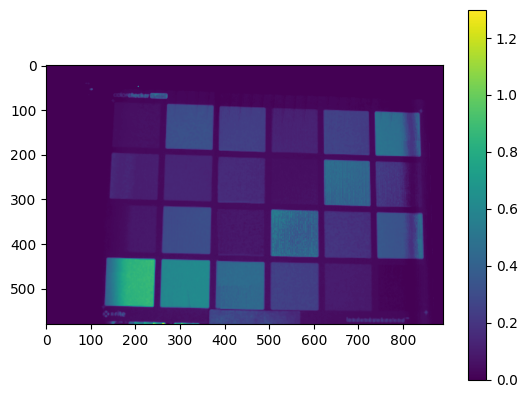

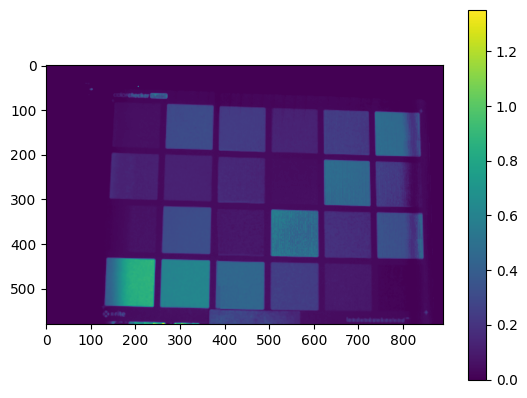

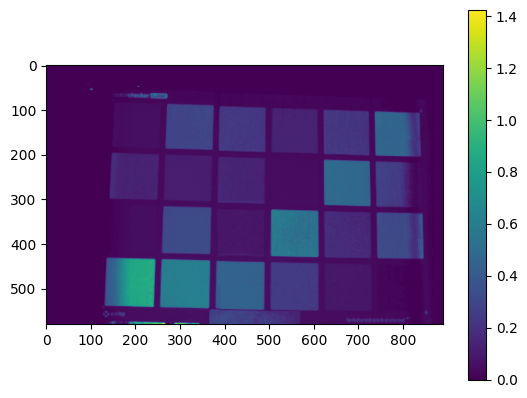

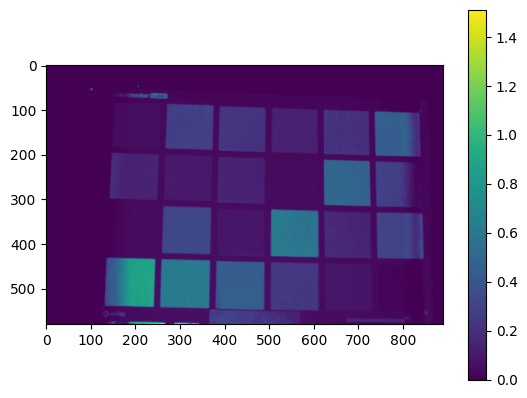

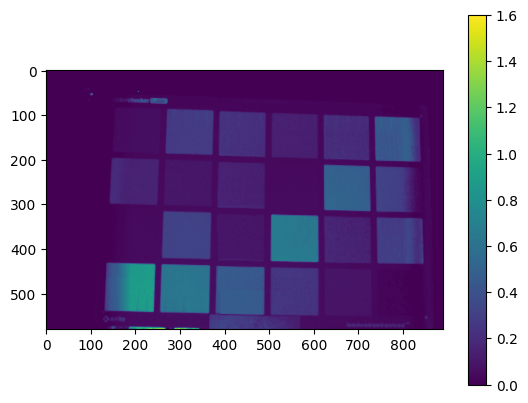

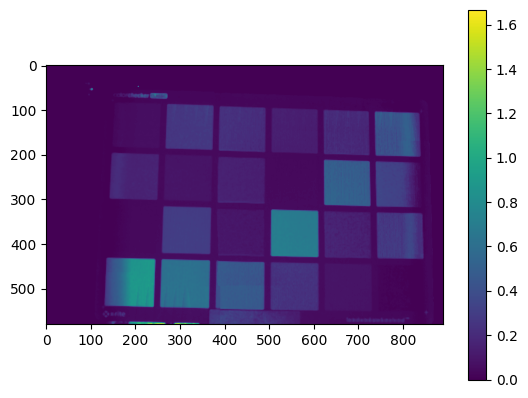

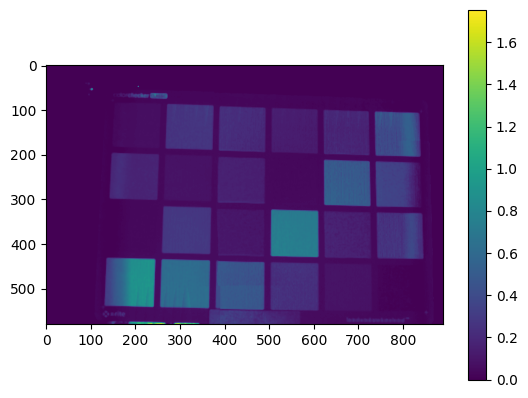

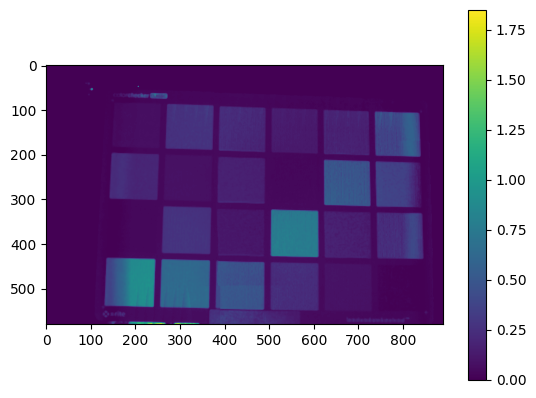

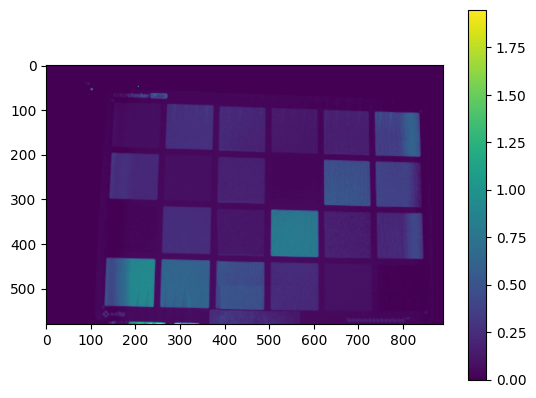

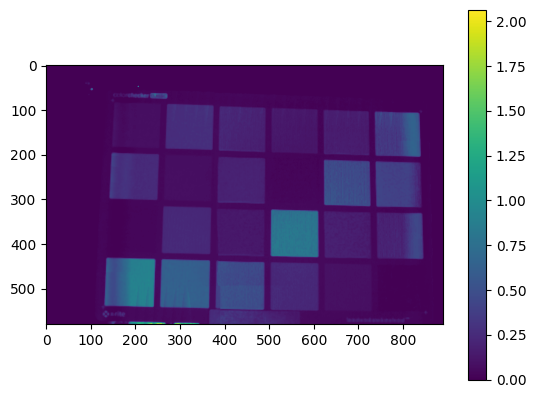

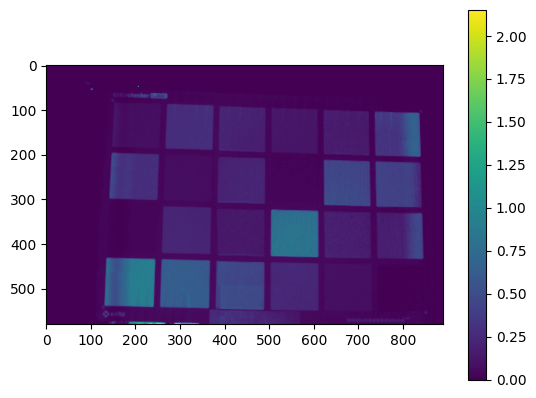

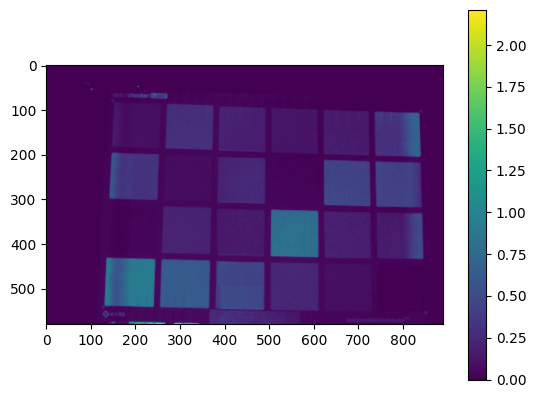

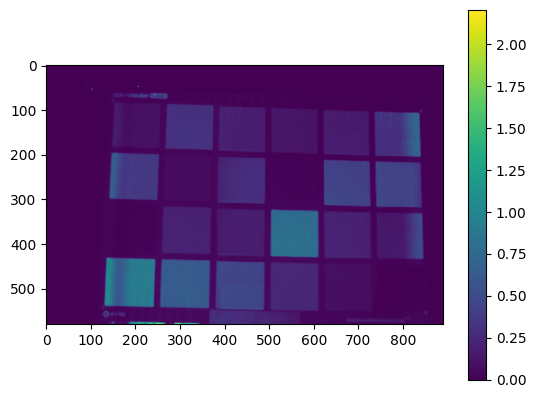

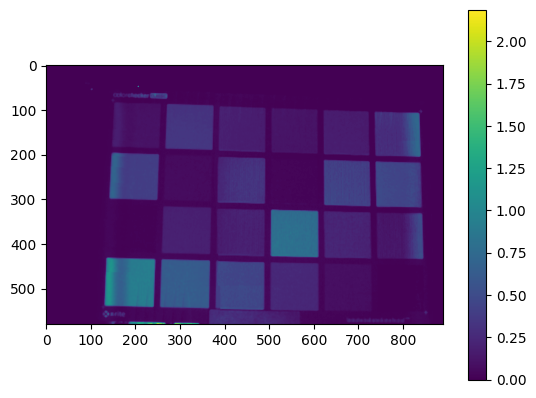

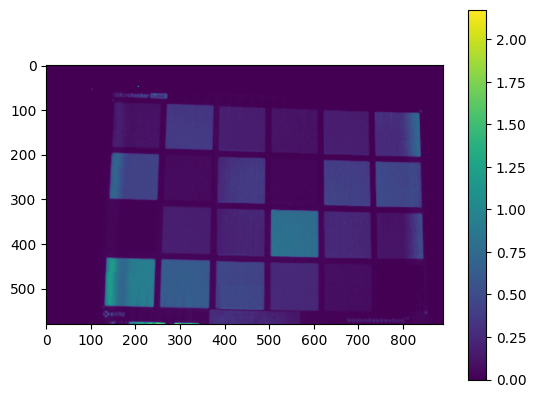

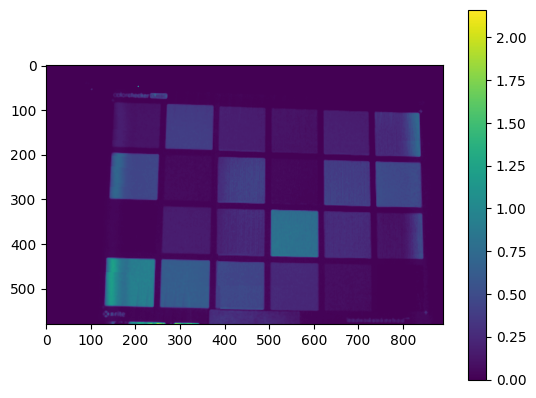

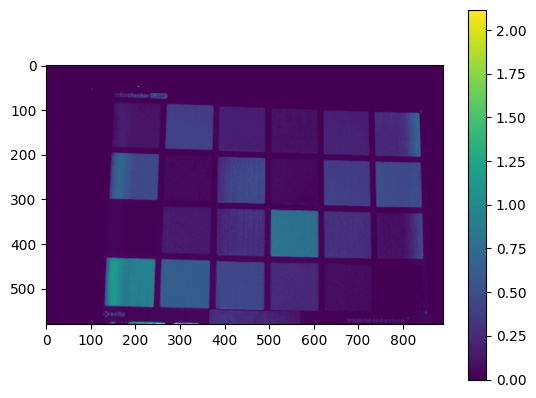

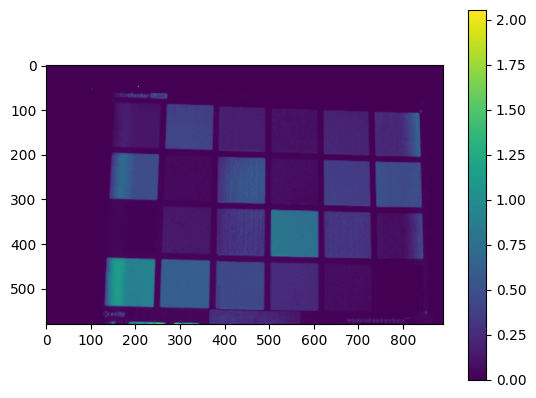

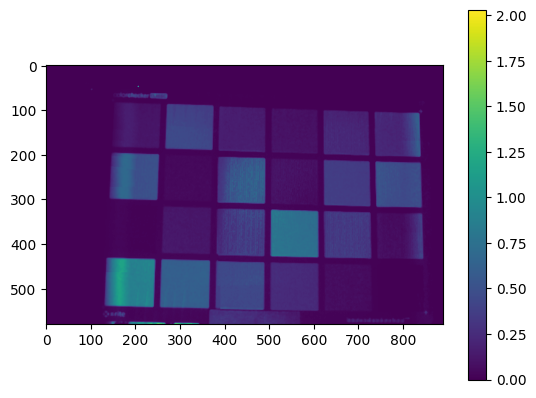

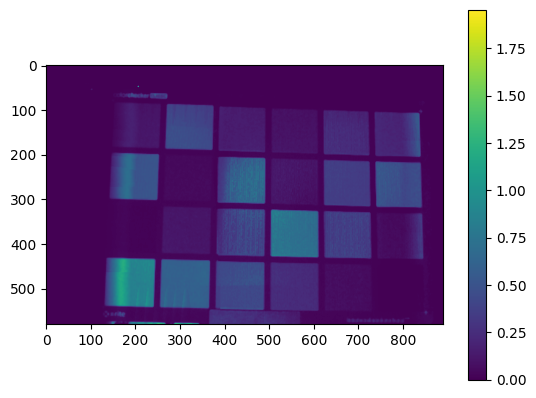

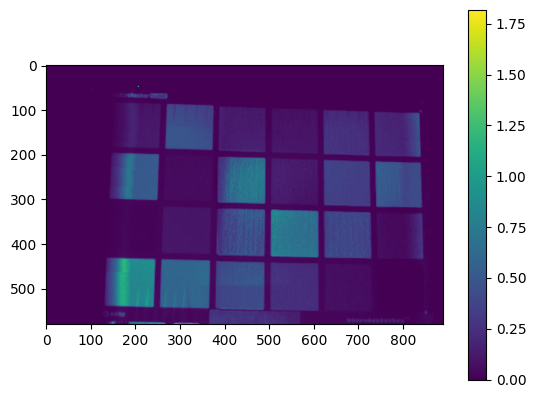

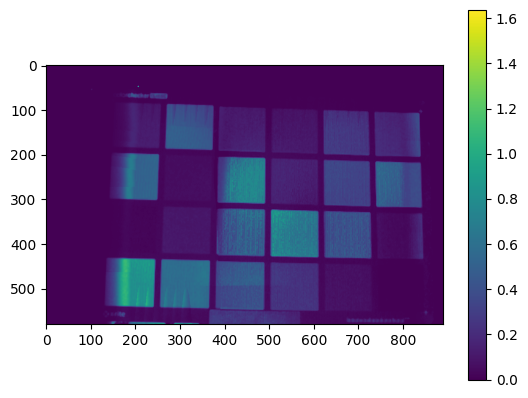

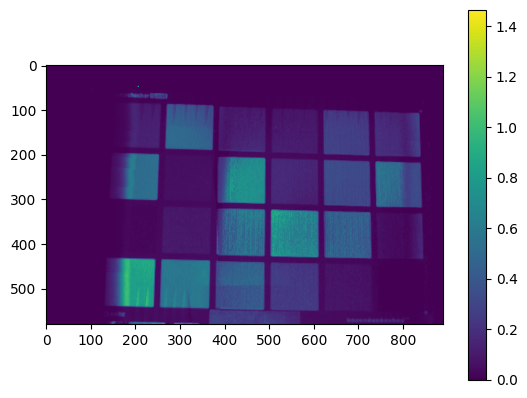

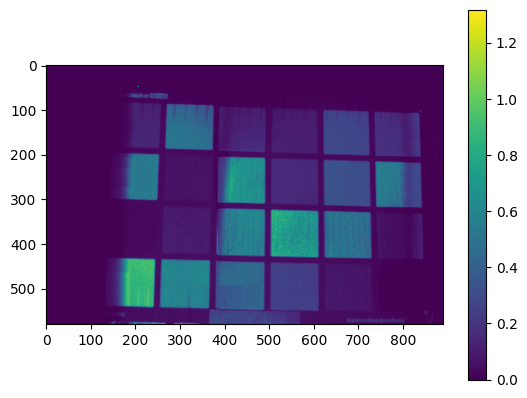

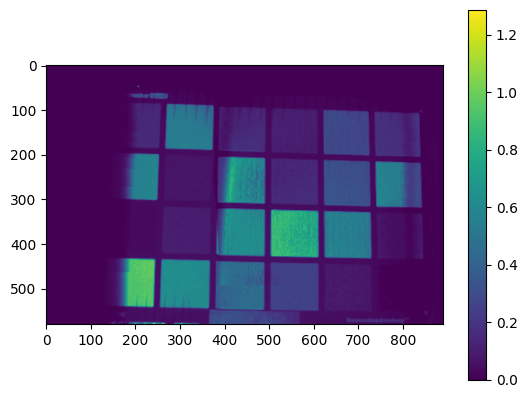

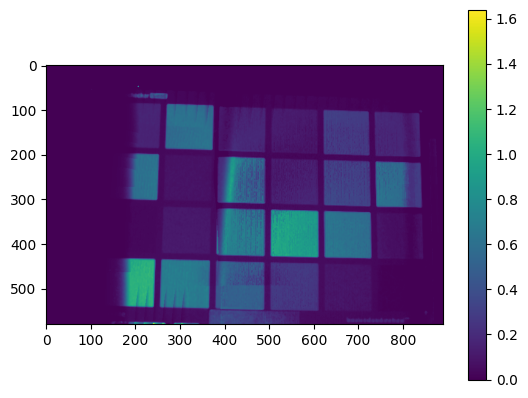

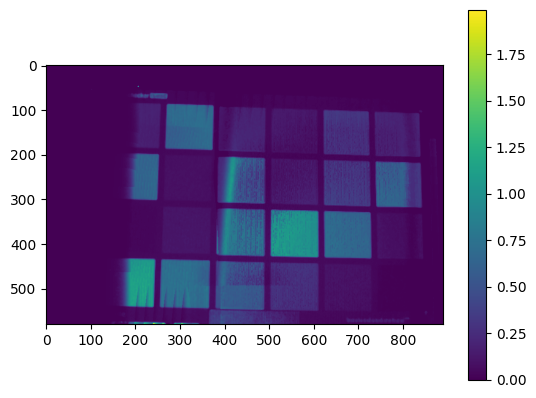

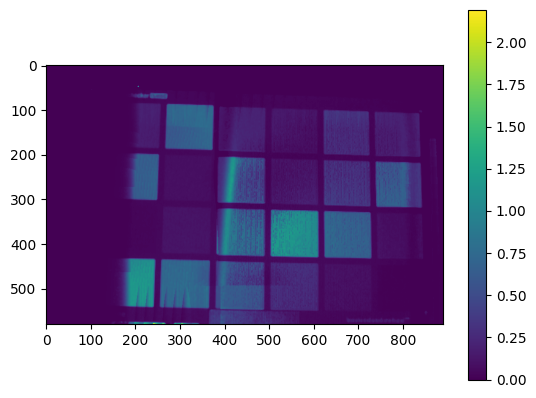

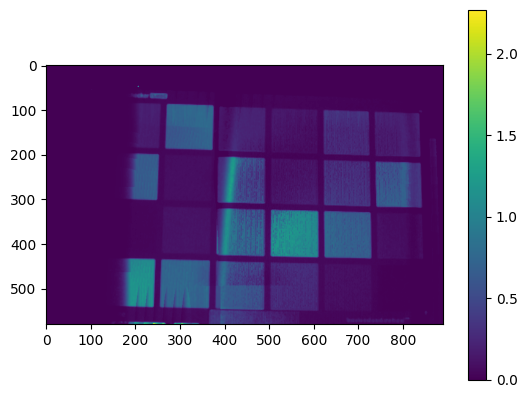

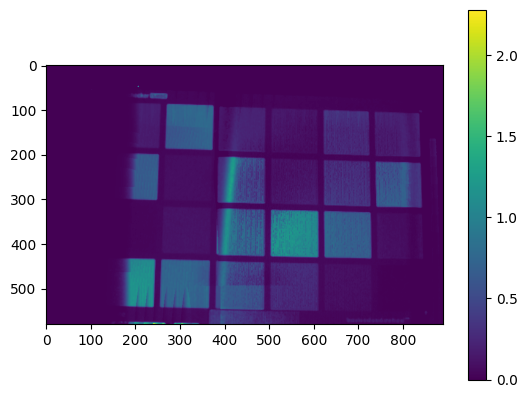

In [59]:
for i in range(n_lambda):
    plt.imshow(csj_x_vis[:,:,i].detach().cpu().numpy())
    plt.colorbar()
    plt.show()

In [64]:
total_hyp_ref @ CRF.type(torch.float16)

RuntimeError: expected scalar type Double but found Half

In [61]:
# for w in range(len(new_wvls)):
#     plt.figure(figsize=(5,3))
#     plt.imshow(total_hyp_ref[:,:,w]), plt.colorbar(), plt.title('%snm'%(new_wvls[w]*1e9))

In [47]:
# for w in range(len(new_wvls)):
#     plt.figure(figsize=(5,3))
#     plt.imshow(total_hyp_ref[:,:,w], vmin = total_hyp_ref.min(), vmax = total_hyp_ref.max()), plt.colorbar(), plt.title('%snm'%(new_wvls[w]*1e9))

### Optimization

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/1000, Loss: 0.10649026930332184, LR: 0.001


KeyboardInterrupt: 

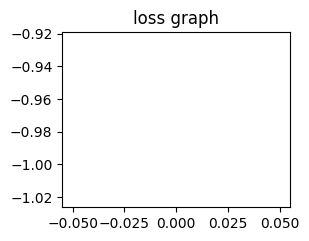

In [48]:
# arguments
device = 'cuda:0'
epoch = 1000
loss_f = torch.nn.L1Loss()
losses = []

# Height, width of image
H, W = cam_H, cam_W

# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, W, 3), device = device, dtype = torch.float)*0.8

# learning rate & decay step
lr = 0.001
decay_step = 300
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(H, W, len(new_wvls))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF_dev = torch.tensor(PEF, dtype = torch.float).to(device).T
CRF_dev = torch.tensor(CRF, dtype = torch.float).to(device).unsqueeze(dim = 0).unsqueeze(dim = 0)
DG_efficiency_image_dev = torch.tensor(DG_efficiency_image.reshape(cam_H, cam_W, len(new_wvls)), dtype = torch.float).to(device)

hdr_imgs_device = torch.tensor(hdr_imgs, dtype = torch.float).to(device)
first_illum_idx_final_transp_device = torch.tensor(first_illum_idx_final_transp, dtype = torch.long).to(device)

rand_idx = [random.randint(0, 21) for _ in range(5)]

x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')
# a = hdr_imgs[first_illum_idx_final_transp, x, y, z].transpose(1, 2, 0, 3)

for i in range(epoch):
    # initial loss
    loss = 0
        
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_dev

    # loss for image
    # H, W, 47, 3         # H, W, wvls, 1                 # H, W, wvls, 1                     H, W, wvls, 1                             # 1, 1, 47, 3
    Simulated_I_RGB = (opt_param.unsqueeze(dim = 3) * white_pattern_hyp.unsqueeze(dim = 3) * DG_efficiency_image_dev.unsqueeze(dim = 3)) * CRF_dev
    GT_I_RGB = hdr_imgs_device[first_illum_idx_final_transp_device, x, y, z].permute(1, 2, 0, 3)
    
    loss = loss_f(Simulated_I_RGB, GT_I_RGB)
    loss = loss.sum()
    
    hyp_dL2 = ((opt_param[:,:,:-1] - opt_param[:,:,1:])**2).sum()

    weight = 0.15
    loss += weight*(hyp_dL2)

    loss = loss.sum()
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    scheduler.step()
        
    if i % 100 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()       
        
        np.save('./calibration/radiometric_cal/opt_params/hyp_img_0919_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses]), plt.title('loss graph')

### Optimized Hyperspectral Image check

In [ ]:
hyp_image = np.load('./calibration/radiometric_cal/opt_params/hyp_img_0919_detach_%05d.npy'%200)

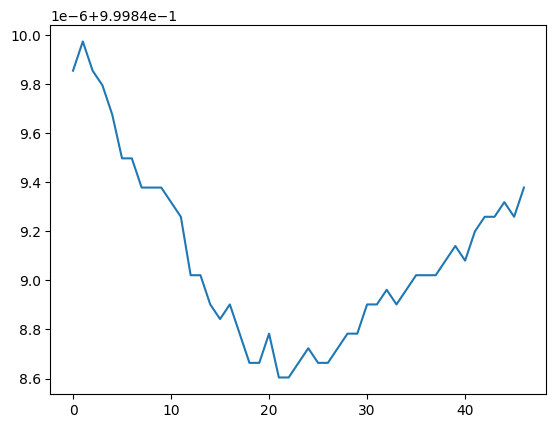

In [ ]:
plt.plot(hyp_image[490,190])

In [ ]:
rgb = hyp_image@CRF

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


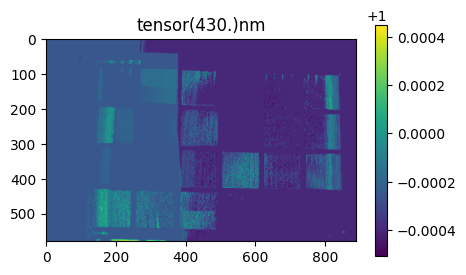

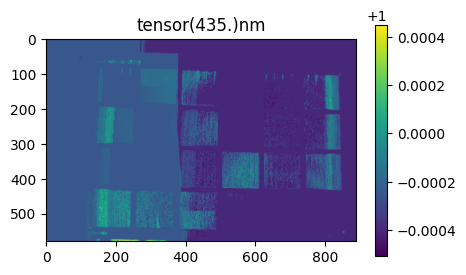

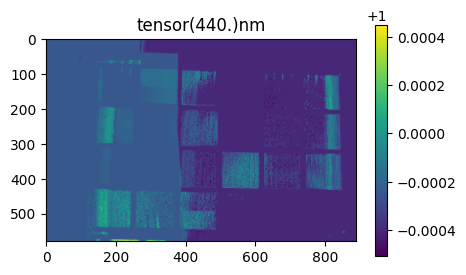

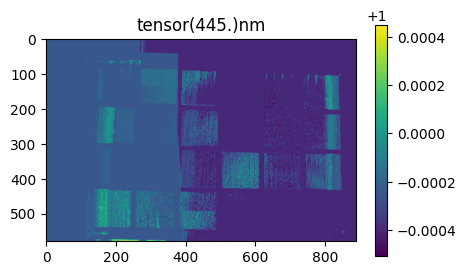

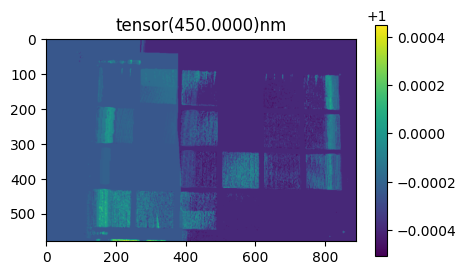

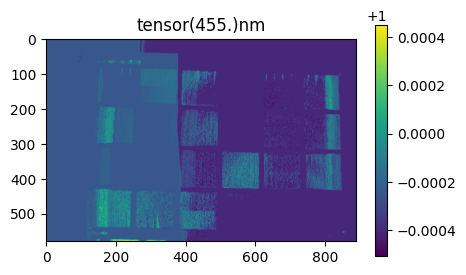

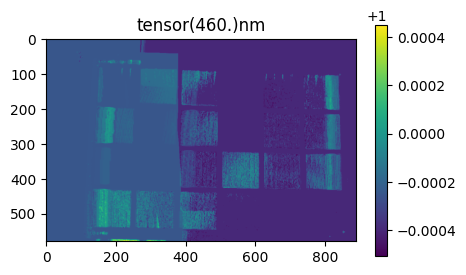

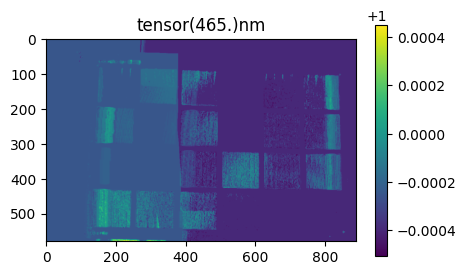

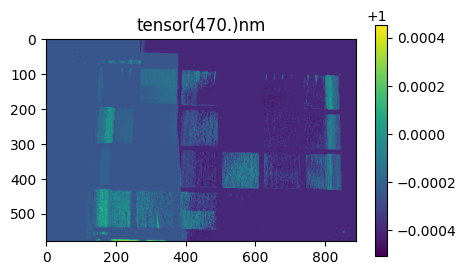

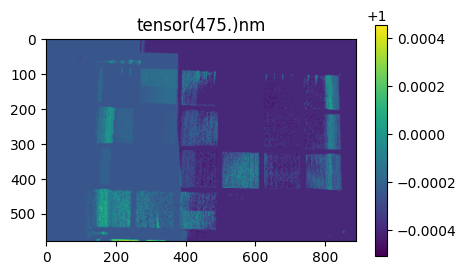

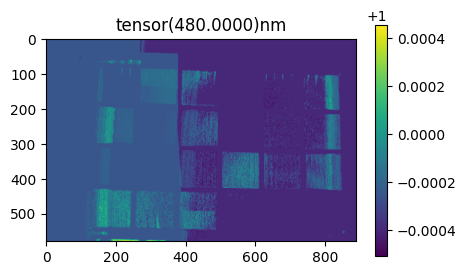

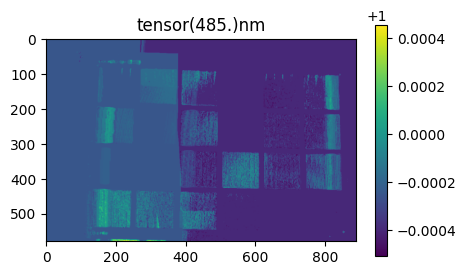

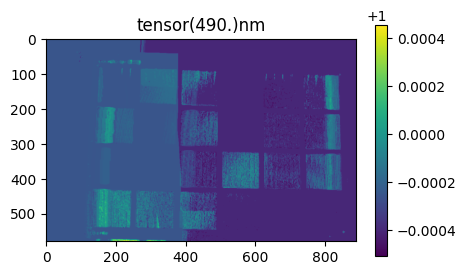

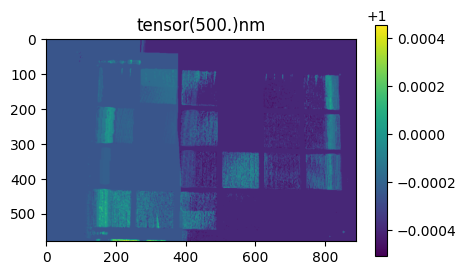

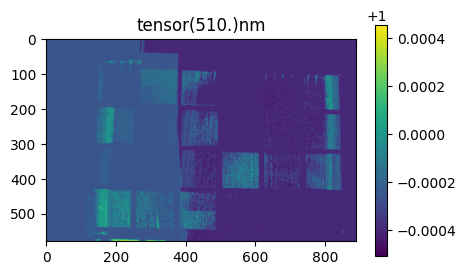

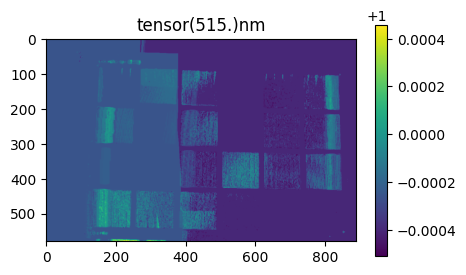

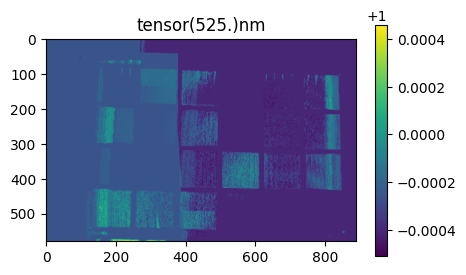

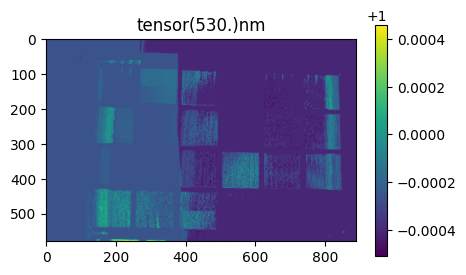

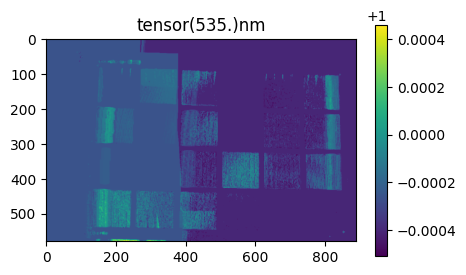

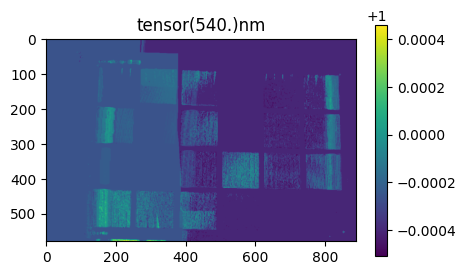

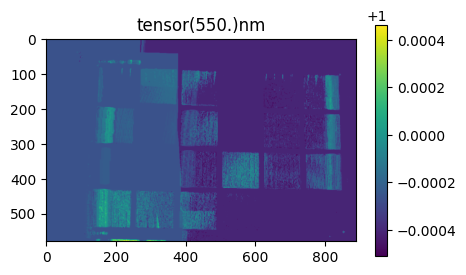

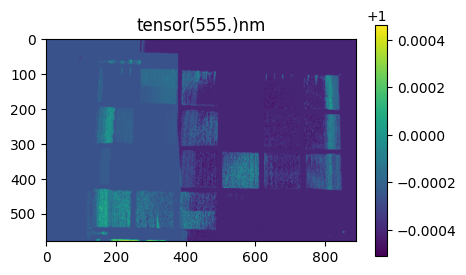

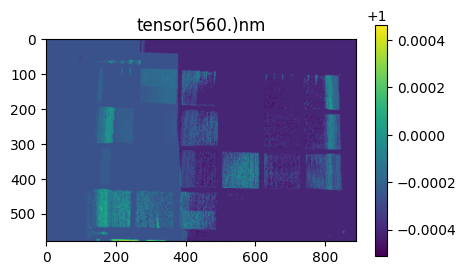

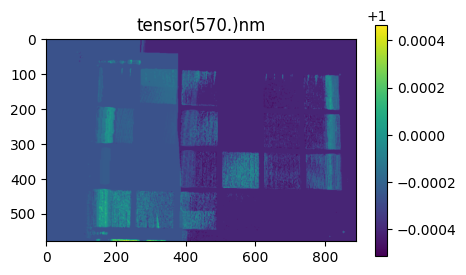

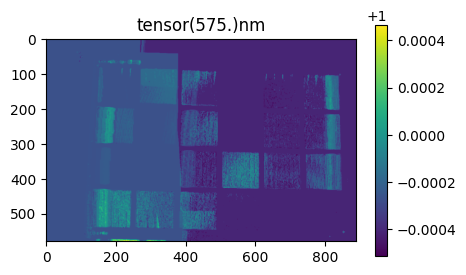

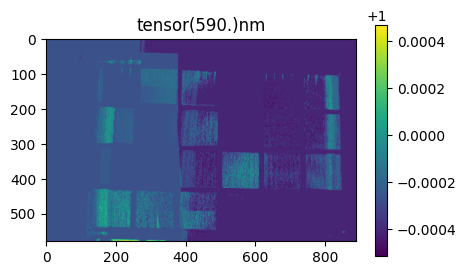

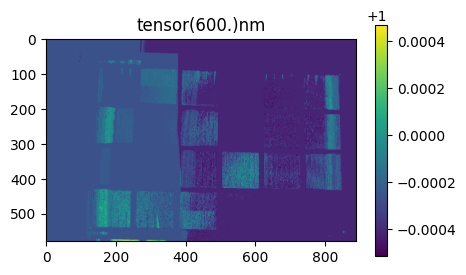

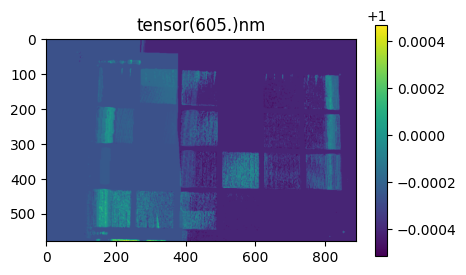

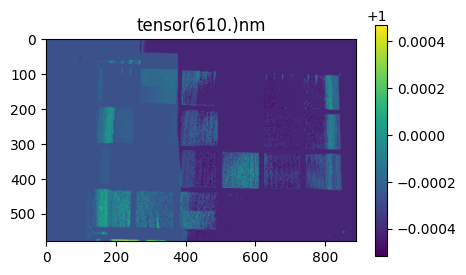

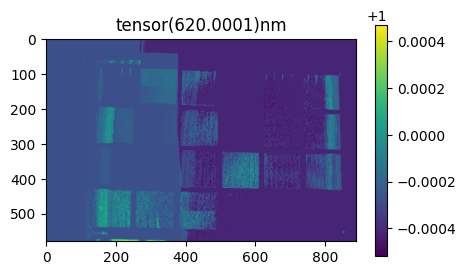

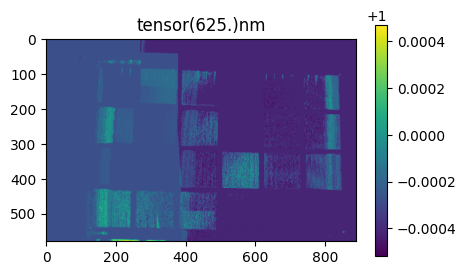

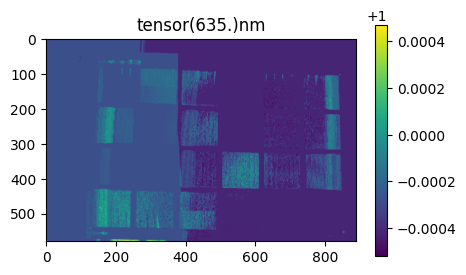

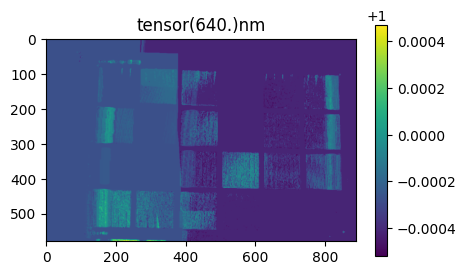

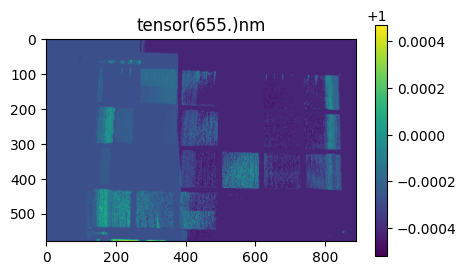

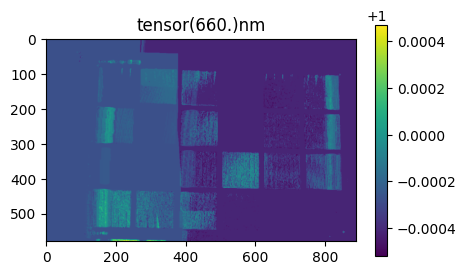

In [ ]:
for w in range(len(new_wvls)):
    plt.figure(figsize=(5,3))
    plt.imshow(hyp_image[:,:,w]), plt.colorbar(), plt.title('%snm'%(new_wvls[w]*1e9))